<a href="https://colab.research.google.com/github/Alex-Chen1121/Machine-learning/blob/main/8_9%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92%E5%8F%AF%E8%A6%96%E5%8C%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!pip install grad-cam
!pip install PyDrive

In [ ]:
from pytorch_grad_cam import (
    GradCAM,
    ScoreCAM,
    GradCAMPlusPlus,
    AblationCAM,
    XGradCAM,
    EigenCAM
)
from pytorch_grad_cam.utils.image import (
    show_cam_on_image,
    preprocess_image
)

from torchvision.models import resnet50
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt
import torch
import numpy as np

In [ ]:
# 安裝 PyDrive 庫


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 授權 Google Drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 模型檔案的 ID
# 共用模型的連結id,view前代碼 (https://drive.google.com/file/d/16I0VF3o270kr6EbbOTHG0G62nFG281Go/view?usp=sharing)
model_id = '16I0VF3o270kr6EbbOTHG0G62nFG281Go'

# 下載模型
output_file = '/content/model.pth'  # 預設叫model，如改名最後一段也要改
downloaded = drive.CreateFile({'id': model_id})
downloaded.GetContentFile(output_file)

import os
if os.path.exists(output_file):
    print("模型下載成功！")
else:
    print("模型下載失敗！請檢查共用連結是否有效。")


In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from PIL import Image
import os


In [ ]:
filepath = "1.jpg"
img_size = 224
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# 定義圖片預處理操作
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # 調整圖片大小
    transforms.ToTensor(),  # 將圖片轉為 Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 正規化圖片
])


In [ ]:
model = torch.load('/content/model.pth',map_location=torch.device('cpu')).to(device)
_ = model.eval()

In [ ]:
model

In [ ]:
target_layer = [model.layer4[-1]]
cam = None

In [ ]:
target_layer = [model.layer4[-1]]
print(target_layer)

In [ ]:
from PIL import Image

def read_img(filepath, img_size=224):
  img = Image.open(filepath).resize((img_size,img_size))
  return img

In [ ]:
img = read_img(filepath)
img = preprocess(img).unsqueeze(0).to(device)
pred = model(img)
pred = torch.nn.Softmax(dim=1)(pred)[0]

print('Top 1 class: ', pred.argmax().item())
values, ids =  torch.topk(pred, k=5) # topk 找出分數最高的k個
print('Top 5 class: ', ids.tolist()) # 類別
print('Top 5 value: ', values.tolist()) # 機率高低

In [ ]:
cls = ['黑貓', '白貓', '橘貓', '黑白貓', '三花貓', '虎斑貓','玳瑁貓']
cls_labels = { idx : cls for idx, cls in enumerate(cls)}
cls_labels

In [ ]:
for i in range(len(ids.tolist())):
  print(cls_labels[ids.tolist()[i]])

In [ ]:
img = read_img(filepath)
print(img)
print(img.copy())
img = preprocess(img)
img.shape


In [ ]:
img = read_img(filepath)
grayscale_cam, cam_on_img = visualize(img.copy(),
                                      GradCAM,
                                      img_size=img_size,
                                      target_category=None)

# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.subplot(1, 3, 2)
plt.imshow(cam_on_img)
plt.subplot(1, 3, 3)
plt.imshow(grayscale_cam, cmap='jet')
plt.show()

In [ ]:
from torchvision.models import ResNet50_Weights
transform =  ResNet50_Weights.DEFAULT.transforms()

In [ ]:
img = read_img(filepath)
input_tensor = transform(img).unsqueeze(0)
input_tensor.shape

In [ ]:
cam = GradCAM(model=model, target_layers=target_layer, use_cuda=False)


In [ ]:
grayscale_cam = cam(input_tensor=input_tensor, targets=None)

In [ ]:
def visualize(img, method, img_size=224, target_category=None):
    # If target_category is None, the highest scoring category
    # will be used for every image in the batch.
    # target_category can also be an integer, or a list of different integers
    # for every image in the batch.

    # Create to torch tensor, add batch dim
    input_tensor = preprocess(img).unsqueeze(0) # (1, 3, img_size, img_size)

    # Construct the CAM object once, and then re-use it on many images:
    cam = method(model=model,
                 target_layers=target_layer,
                 use_cuda=False)

    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor,
                        # target_category=target_category)
                        targets=target_category)

    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]
    cam_on_img = show_cam_on_image(np.array(img)/255., grayscale_cam, use_rgb=True)

    return grayscale_cam, cam_on_img

## 上傳一張要辨識的貓咪照

In [ ]:
filepath =  'tiger.jpg' #'dogcat.png' #'both2.jpeg'
img_size = 224
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#
from torchvision.models import ResNet50_Weights # resnet的前處理方法
# Preprocess Transform
transform =  ResNet50_Weights.DEFAULT.transforms()

# 舊的前處理方法
# # ImageNet transform
# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((img_size, img_size)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

In [ ]:
model = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)


In [ ]:
model.fc = nn.Linear(2048, 7)

In [ ]:
_ = model.eval()

In [ ]:
target_layer = [model.layer4[-1]]

cam = None

In [ ]:
from PIL import Image

def read_img(filepath, img_size=224):
    img = Image.open(filepath).resize((img_size, img_size))
    return img

In [ ]:
def visualize(img, method, img_size=224, target_category=None):
    # If target_category is None, the highest scoring category
    # will be used for every image in the batch.
    # target_category can also be an integer, or a list of different integers
    # for every image in the batch.

    # Create to torch tensor, add batch dim
    input_tensor = transform(img).unsqueeze(0) # (1, 3, img_size, img_size)

    # Construct the CAM object once, and then re-use it on many images:
    cam = method(model=model,
                 target_layers=target_layer,
                 use_cuda=False)

    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor,
                        # target_category=target_category)
                        targets=target_category)

    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]
    cam_on_img = show_cam_on_image(np.array(img)/255., grayscale_cam, use_rgb=True)

    return grayscale_cam, cam_on_img

In [ ]:
img = read_img(filepath)
img = transform(img).unsqueeze(0).to(device)
pred = model(img)
# convert to probabilities of each classes
pred = torch.nn.Softmax(dim=1)(pred)[0]

print('Top 1 class: ', pred.argmax().item())
values, ids =  torch.topk(pred, k=5) # topk 找出分數最高的k個
print('Top 5 class: ', ids.tolist()) # 類別
print('Top 5 value: ', values.tolist()) # 機率高低

Top 1 class:  2
Top 5 class:  [2, 4, 3, 1, 5]
Top 5 value:  [0.16164089739322662, 0.14701507985591888, 0.14658690989017487, 0.14652571082115173, 0.1371699422597885]


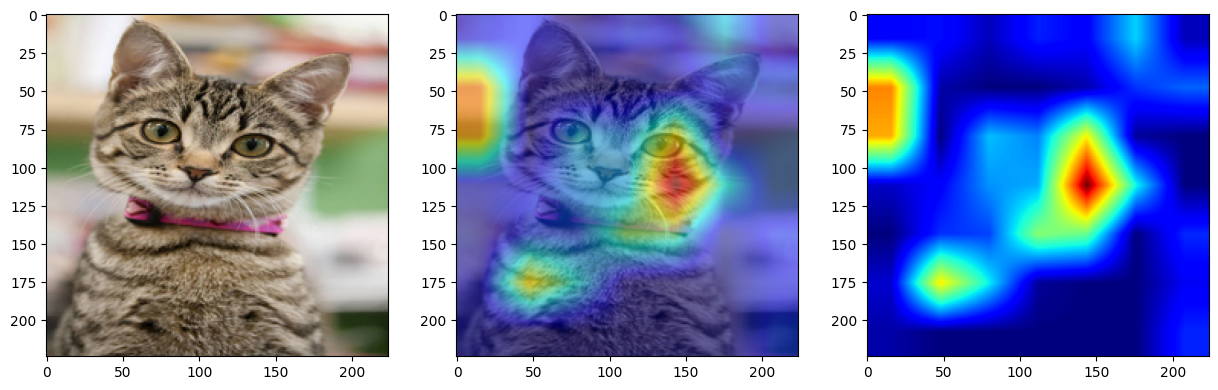

In [ ]:
img = read_img(filepath)
grayscale_cam, cam_on_img = visualize(img.copy(),
                                      GradCAM,
                                      img_size=img_size,
                                      target_category=None)

# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.subplot(1, 3, 2)
plt.imshow(cam_on_img)
plt.subplot(1, 3, 3)
plt.imshow(grayscale_cam, cmap='jet')
plt.show()